In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ADM1_class import ADM1_instance
from scipy import stats

In [89]:
def Chi_Squared(observed_data_x, observed_data_y, expected_data_x, expected_data_y):
    #observed is from simulation
    observed_data_x = np.array(observed_data_x) 
    observed_data_y = np.array(observed_data_y)
    
    #expected is base truth
    expected_data_x = np.array(expected_data_x) 
    expected_data_y = np.array(expected_data_y)

    dof = -1
    chi_squared = 0
    for i in (expected_data_x):
        a = observed_data_y[np.where(observed_data_x == i)[0][0]]
        b = expected_data_y[np.where(expected_data_x == i)[0][0]]
        
        dof +=1
        chi_squared += (a - b)**2 / (b)
    p = 1 - stats.chi2.cdf(chi_squared, dof)
    
    return chi_squared, dof, p

def dilution(instance, data_simulation, data_observation, t_simulation, t_observation):
    #other process producing baseline methane
    #simple dilution using a half sphere to compare the found concentration to the simulated concentration a distance away from the source
    v1 = instance.V_gas 
    c1 = data_simulation['P_ch4'].max() #-  data_simulation['P ch4'].min() #amplitude of this data
    t_sim_temp = data_simulation[data_simulation['P_ch4'] == data_simulation['P_ch4'].max()].index.values
    c1_t = t_simulation[t_sim_temp]#time of maximum simulated data
    
    c2 = max(data_observation)# - min(data_observation) #amplitude of this data
    c2_t = t_observation[data_observation.index(max(data_observation))] #index of maximum observed data
    
    r = ((3 * c1 * v1) /( 8* np.pi * c2))**(1/3) #calculate distance based on half dome dilution [m]
    v2 = r**3 * 8/3 * np.pi #volume of second half sphere used to recalculate other gas concentrations [m^3]
     
    #time shift
    time_shift = abs(c1_t - c2_t) #this calculated the difference in time between the peaks of the observed and measured data
    
    new_data_simulation = data_simulation * (v1/v2) #calculate other gas concentrations
    
    return new_data_simulation, r, time_shift

def Monte_carlo(reactor, func, x_avr, x_std, sims, ref_x, ref_y):
    solutions = [] #p, r
    shots = []
    #Monte Carlo error analysis    
    x_avr_np = x_avr
    x_avr_np = np.array(x_avr_np)
    
    for i in range(sims):
        #pick new uncertain x members
        x_MC = (x_avr_np.transpose() + (x_std * np.random.randn(len(x_avr)))).transpose()
        shots.append(x_MC)
        
        #find new y values with new x this is specific for the ADM1 based function
        y_MC = func(reactor, ref_x, x_MC)
        
        #find new coefficient
        #eddited_data = dilution(instance, data_simulation, data_observation, t_simulation, t_observation)
        
        solutions.append(y_MC)
        print("run", i)
    
    #calculate mean and stdev of Monte Carlo results
    return solutions, np.array(shots)

def analyse(reactor, t, x):
    #this function is used to wrangle the variables into a format suitable for both the ADM1 class, and the statistical tests
    
    #set new numbers
    reactor.V_liq = x[-2]
    reactor.V_gas = x[-1]
    
    reactor.inital_states = pd.DataFrame(x_avr[:-2], index = reactor.initial_state.keys())

    #generate results
    solution, gasses, t_sim = reactor.dyn_sim(t.max() + 1, resolution = 100, feedback = False) #generate results from simulation, [gCOD/L], [Bar], [days]
    P_gasses = ['P_h2', 'P_ch4', 'P_H2S']
    advanced_gasses = gasses[P_gasses]
    advanced_gasses /= Mars_atmosphere[-1][-1] * 10e-9 #convert to ppbv 
    data, r, dt = dilution(reactor, advanced_gasses, CH4_observations, t_sim, t_rover)
    a = Chi_Squared(np.array(t_sim.tolist())[:-1], data.P_ch4, observed.loc['x'], observed.loc['y'])  
    
    return a[0], r, a[2]

def parse_data_to_file(filename, results):
    #this method allows data to be added to a file. This enables multiple runs of the montecarlo analysis to be performed independantly of machine stability by offloading RAM usage into permanent storage.
    try:
        file_original = pd.read_csv(filename)
        file = file_original.append(results, ignore_index=True)
        print("Filename found, appending.")
        
    except:  
        file = results
        print("No file found, creating new file.")
    
    file.to_csv((filename), index = False)
    

In [90]:
mars_instance = ADM1_instance(T_ad = 298.15, V_liq = 3400, V_gas = 300, p_atm = 1.013, q_ad = 0) #[K], [m^3], [m^3], [bar], [m^3/ d]

#Mars peak data
t_rover = [-1,0, 1, 8, 11, 13]
CH4_observations = [3, 5.78, 15.5, 2.13, 5, 5] #ppbv
Mars_atmosphere = [['Co2', 'N2', 'Ar', 'O2', 'CO', 'P'],[0.951, 0.0259, 0.0194, 0.0016, 0.008]]
observed = pd.DataFrame([np.array(t_rover) + 1 , CH4_observations], ['x', 'y'])

#define montecarlo avarages in an array
x_avr = mars_instance.initial_state.transpose().iloc[:,0].to_list()[:]
x_avr.append(mars_instance.V_liq)
x_avr.append(mars_instance.V_gas)

#define standart deviation as 1/4th the magnitude of the avarage
x_std = np.array(x_avr) / 4

In [91]:
#start analysis
#do 'sims' iterations of the ADM1 simulation with different initial values, and write the reults to 'file_name'
file_name = "results.csv"

sims = 150
ans = Monte_carlo(mars_instance, analyse, x_avr, x_std, sims, observed.loc['x'], observed.loc['y'])
results = pd.DataFrame(ans[0], columns =['Chi-value', 'r', 'p_value'])

parse_data_to_file(file_name, results)

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
run 20
run 21
run 22
run 23
run 24
run 25
run 26
run 27
run 28
run 29
run 30
run 31
run 32
run 33
run 34
run 35
run 36
run 37
run 38
run 39
run 40
run 41
run 42
run 43
run 44
run 45
run 46
run 47
run 48
run 49
run 50
run 51
run 52
run 53
run 54
run 55
run 56
run 57
run 58
run 59
run 60
run 61
run 62
run 63
run 64
run 65
run 66
run 67
run 68
run 69
run 70
run 71
run 72
run 73
run 74
run 75
run 76
run 77
run 78
run 79
run 80
run 81
run 82
run 83
run 84
run 85
run 86
run 87
run 88
run 89
run 90
run 91
run 92
run 93
run 94
run 95
run 96
run 97
run 98
run 99
run 100
run 101
run 102
run 103
run 104
run 105
run 106
run 107
run 108
run 109
run 110
run 111
run 112
run 113
run 114
run 115
run 116
run 117
run 118
run 119
run 120
run 121
run 122
run 123
run 124
run 125
run 126
run 127
run 128
run 129
run 130
run 131
run 132
run 133
run 134
run 135
run 136
run 137
run 13

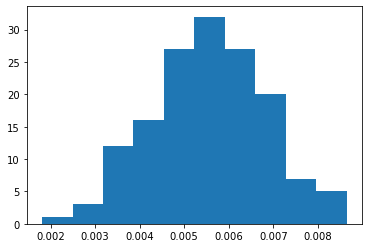

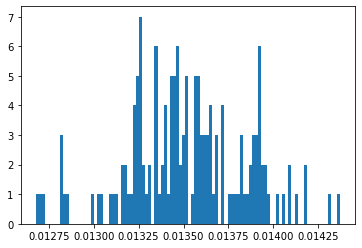

In [92]:
shots = np.array(ans[1])
plt.figure()
a = plt.hist(shots[:,1], bins = 10)
plt.figure()
a = plt.hist(results.p_value, bins = 100)